In [1]:
%matplotlib widget
%reload_ext autoreload
%autoreload 2
import numpy as np
from pyrfu.plot import plot_line, plot_spectr
from pyrfu import mms
import matplotlib.pyplot as plt
from matplotlib import gridspec

plt.style.use('../msc-project/figstyle.mplstyle')
from matplotlib.font_manager import fontManager
fontManager.addfont('../msc-project/fonts/TIMES.TTF')



Load IGRF coefficients ...


In [2]:
data = np.genfromtxt(f'output_data/stats/density_correction_stats.csv', delimiter=',', names=True, skip_header=0, dtype=None)
# Convert to dictionary for easy unpacking
data_dict = {name: data[name] for name in data.dtype.names}

# Unpack values
start_str_, stop_str_, c0_, vsc_mean_, t_e_mean_, beta_, N0_, ic_= data_dict.values()
start_dts_ = np.array(start_str_, dtype='datetime64')
stop_dts_ = np.array(stop_str_, dtype='datetime64')
sw_mode = np.ones_like(c0_)*2
idxs_all = [(ic_ == i) for i in range(1,5)]

(array([1.38485473, 1.11878532, 1.07091487, ..., 1.36200484, 1.37540251,
        1.39666338]),
 array(['2021-01-08T14:57:00.000000000', '2021-02-05T14:02:20.000000000',
        '2021-02-05T14:12:20.000000000', ...,
        '2022-01-02T23:52:00.000000000', '2022-01-03T00:02:00.000000000',
        '2022-01-03T00:12:00.000000000'], dtype='datetime64[ns]'))

# Time evolution of C

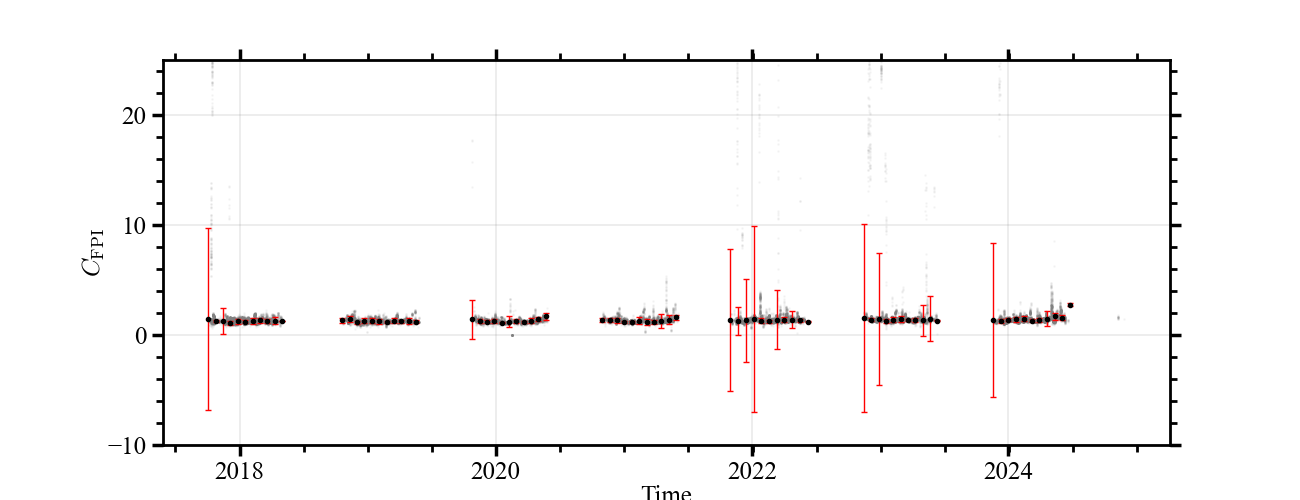

In [37]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
ic = 1
c0 = c0_[idxs_all[ic-1]][1:]
start_dts = start_dts_[idxs_all[ic-1]][1:]
# Clean data
# c0 = np.where((c0 > 0.25) & (c0 < 3), c0, np.nan)
c0_da = xr.DataArray(c0, dims="time", coords={"time": start_dts}).sortby('time')[1:]

# Compute overall running median and std using resampling
days: int = 30

segments = []
segment_times = []
segment_medians = []
segment_stds = []

# Plot
fig, ax = plt.subplots(figsize=(13, 5))

for i in range(1,8):  # 7 segments
    s = c0_da.time.data[0] + np.timedelta64(365, 'D')*(i-1)
    e = s + np.timedelta64(365, 'D')

    # Select data in range
    idxs = np.where((c0_da.time >= s) & (c0_da.time < e))
    segment = c0_da[idxs]
    segments.append(segment)
    segment_times.append([s, e])
    dt_days = np.timedelta64(segment.time.data[-1] - segment.time.data[0]).astype('timedelta64[D]')
    days = np.int32(dt_days)//10
    median =  segment.resample(time=f"{days}D").median()
    std = segment.resample(time=f"{days}D", closed='right').std()
    segment_medians.append(median)
    segment_stds.append(std)
    
    # plot_line(ax, median, linewidth=1, marker='o', color='black')
    # ax.fill_between(median.time, median - std, median + std, color='red', alpha=0.3, zorder=6)
    ax.errorbar(median.time.data, median.data, yerr=std.data, fmt='.', capsize=2, color='black', elinewidth=1, ecolor='red')

plot_line(ax, c0_da, marker='o', linestyle='none', color='grey',markersize=1, zorder=1, alpha=0.05)
ax.set_ylim(-10, 25)
ax.set_xlabel('Time')
ax.set_ylabel(r'$C_\mathrm{FPI}$')
plt.show()


# 2D Histogram of T_e and C_FPI 

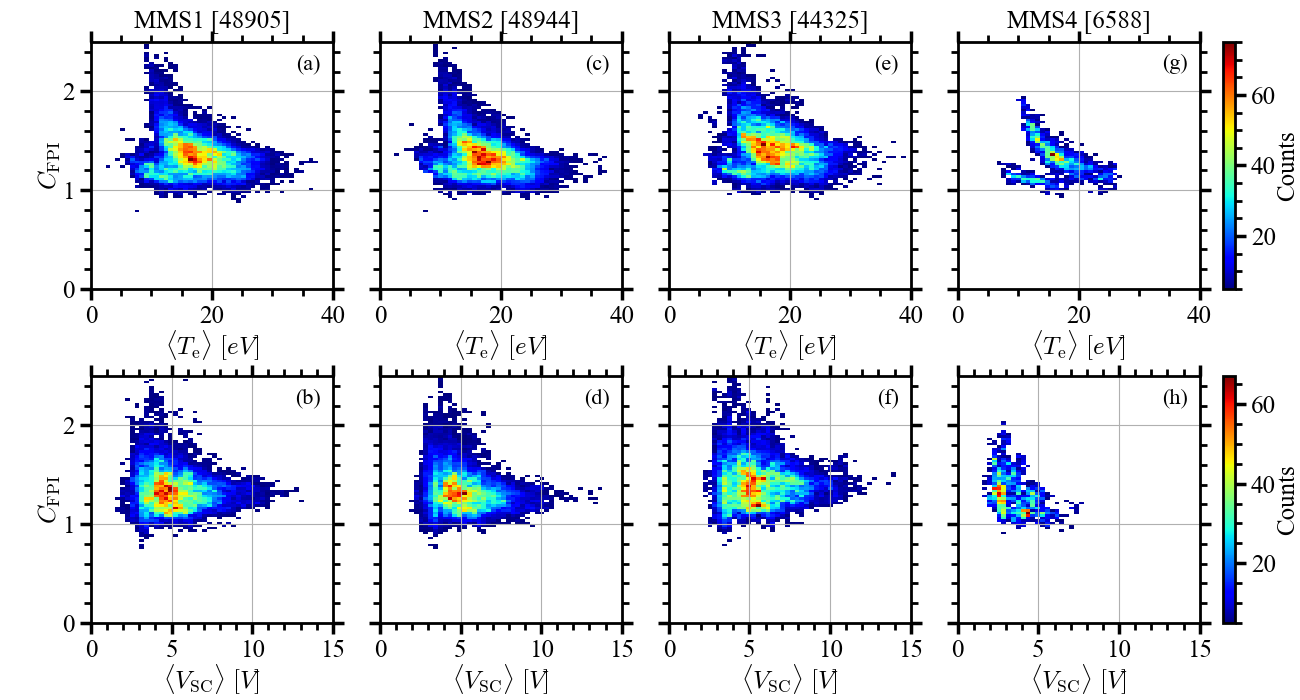

In [26]:
plt.close('all')
# fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(13, 9))
# plt.subplots_adjust(right=0.98, left=0.1, hspace=0.4, wspace=0.2, top=0.94)
fig = plt.figure(figsize=(13, 7))
nrows, ncols = 3, 7
# Width of C panel, Data panel, and Space
cw, dw, sw = 0.035, 0.17, 0.04
# gs = gridspec.GridSpec(nrows, ncols, right=0.98, left=0.07, hspace=0, wspace=0, top=0.94, height_ratios=[0.325, 0.1, 0.15, 0.325, 0.1], #width_ratios=[0.08 , 0.23, 0.23, 0.23, 0.23 ]
#                        width_ratios=[cw, dw, sw, cw, dw, sw, cw, dw, sw, cw, dw])
gs = gridspec.GridSpec(nrows, ncols+2, right=0.95, left=0.07, hspace=0, wspace=0, top=0.94, height_ratios=[0.425, 0.15, 0.425],
                       width_ratios=[cw+dw, sw, cw+dw, sw, cw+dw, sw, cw+dw, 0.02,0.01])
axs = np.empty((nrows, ncols), dtype='object')

data_cols = [0, 2, 4, 6]

c_cols = [0, 3, 6, 9]
data_rows = [0, 2]



# panel_labels = [['(a)', '(b)', '(c)', '(d)'], ['(e)', '(f)', '(g)', '(h)']]
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

lab_idx = 0
for col in range(ncols):
    if col in c_cols+data_cols:
        ic = int((col/ 2) + 1)
        if ic not in [1, 2, 3, 4]:
            ic += 1

        ic_idxs = idxs_all[ic-1]
        #start_str_, stop_str_, c0_, vsc_mean_, t_e_mean_, beta_, N0_, ic_
        c0 = c0_[ic_idxs]
        vsc_mean = vsc_mean_[ic_idxs]
        t_e_mean = t_e_mean_[ic_idxs]
        # sw_mode
        ON_idxs = np.where(sw_mode == 1)[0]
        OFF_idxs = np.where(sw_mode == 0)[0]

        # clean up c0 vals
        c0 = np.where(c0 > 0.25, c0, np.nan)
        color_ON, color_OFF = 'red', 'black'
        color_map = {0: color_OFF, 1: color_ON, 2: 'b'}
        colors = np.array([color_map[val] for val in sw_mode])
        # count non-nan datapoints
        npoints = np.count_nonzero(~np.isnan(c0))
        
        # clean up Te and Vsc
        t_e_mean = np.where(t_e_mean < 60, t_e_mean, np.nan)
        vsc_mean = np.where(abs(vsc_mean) < 30, vsc_mean, np.nan)


    # ax1, ax2, ax3, ax4 = axs

    for row in range(nrows):  # Iterate over rows
        #for col in range(axs.shape[1]):  # Iterate over columns
        # ax = axs[row, col]

        # Add data panel
        if col in data_cols and row in data_rows:
            
            ax = fig.add_subplot(gs[row, col])
            
            if row == 0:
                ax.set_title(f'MMS{ic} [{npoints}]')
                ax.set_xlabel(r'$\langle T_\mathrm{e} \rangle\ [eV]$')
                
                # 2D hist
                counts_ALL, xbins_ALL, ybins_ALL, img_ALL = ax.hist2d(t_e_mean[:], c0[:], bins=[50, 100],range=[[0, 40], [0,2.5]], cmap='jet', cmin=5)
                cmin = 1
                counts_ON, xbins_ON, ybins_ON, img_ON = ax.hist2d(t_e_mean[ON_idxs], c0[ON_idxs], bins=[50, 100],range=[[0, 40], [0,2.5]], cmap='jet', cmin=cmin, alpha=0)
                
                
                # Contour lines of SW ON data
                counts_ON_masked = np.where(counts_ON > cmin, counts_ON, np.nan)
                ax.contour(
                    counts_ON_masked.T, 
                    extent=[xbins_ON.min(),xbins_ON.max(),ybins_ON.min(),ybins_ON.max()], 
                    colors='magenta', 
                    zorder=6, 
                    levels=[10, 60], 
                    linewidths=1.5)
                
                # ax.grid(0)
                

            elif row == 2:
                ax.hist2d(vsc_mean[:], c0[:], bins=[50, 100],range=[[0, 15], [0, 2.5]], cmap='jet', cmin=5)
                ax.set_xlabel(r'$\langle V_\mathrm{SC} \rangle\ [V]$')

            if col == 0:
                ax.set_ylabel(r'$C_\mathrm{FPI}$') 
            else:
                ax.set_yticklabels([])
                
            ax.text(0.95, 0.95, panel_labels[lab_idx], transform=ax.transAxes, va='top', ha='right', fontsize=16)
            lab_idx +=1
            

        axs[row, col] = ax

# Create colorbar axes in the last column
cbar_ax_top = fig.add_subplot(gs[0, -1])  # Top row colorbar
cbar_ax_bottom = fig.add_subplot(gs[2, -1])  # Bottom row colorbar

# Add colorbars to the rightmost histograms
cbar_top = fig.colorbar(axs[0, 6].collections[0], cax=cbar_ax_top)
cbar_bottom = fig.colorbar(axs[2, 6].collections[0], cax=cbar_ax_bottom)
cbar_ax_top.grid(0)
cbar_ax_bottom.grid(0)


# Set colorbar labels
cbar_top.set_label('Counts')
cbar_bottom.set_label('Counts')

plt.show() 

# Correction for $\langle T_e \rangle$

[15-Apr-25 13:29:20] WARNING: /tmp/ipykernel_64738/2664633552.py:13: RuntimeWarning: Mean of empty slice
  tmon_mean = np.nanmean(tmon)

[15-Apr-25 13:29:20] WARNING: /tmp/ipykernel_64738/2664633552.py:20: RuntimeWarning: Mean of empty slice
  tmoff_mean = np.nanmean(tmoff)



[15-Apr-25 13:29:20] WARNING: /tmp/ipykernel_64738/2664633552.py:42: RuntimeWarning: Mean of empty slice
  tmon_corr_mean = np.nanmean(tmon_corr)

[15-Apr-25 13:29:20] WARNING: /tmp/ipykernel_64738/2664633552.py:47: RuntimeWarning: Mean of empty slice
  tmoff_corr_mean = np.nanmean(tmoff_corr)



ON nan nan 10^4 K
OFF  nan nan
corr ON nan nan
corr OFF  nan nan


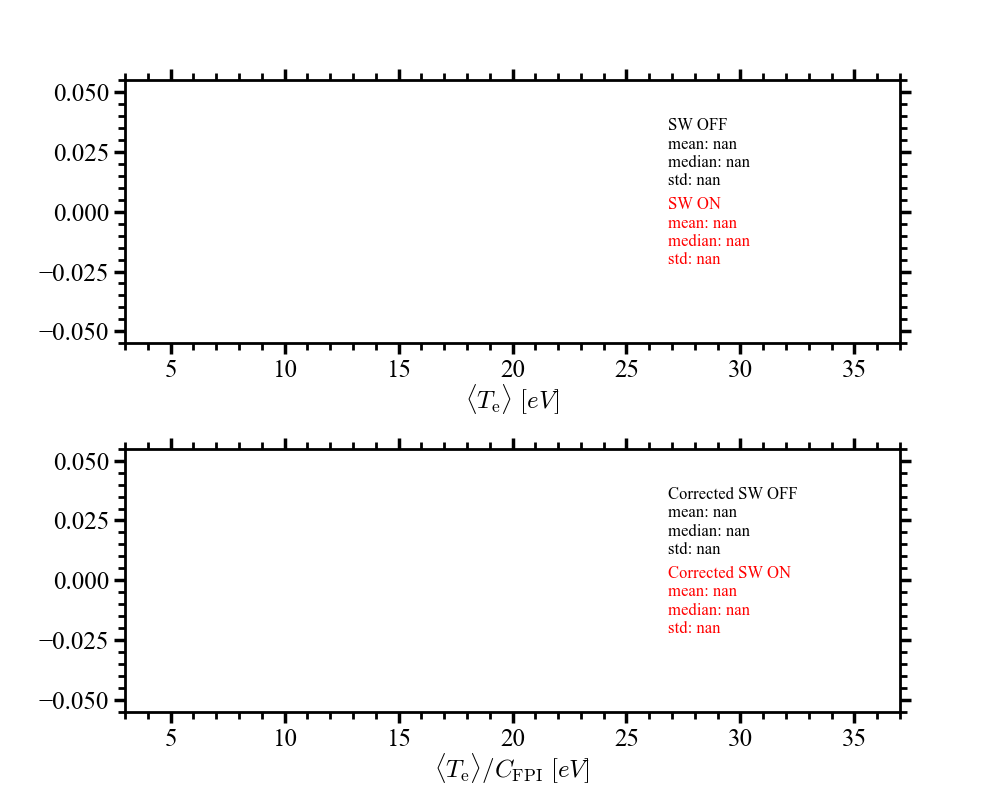

In [39]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4, top=0.9)
ax1, ax2 = axs
ax1.grid(0)
ax2.grid(0)


b = 35

tmoff = t_e_mean[OFF_idxs]
tmon = t_e_mean[ON_idxs]

tmon_mean = np.nanmean(tmon)
tmon_median = np.nanmedian(tmon)
tmon_std = np.nanstd(tmon)



tmoff_median = np.nanmedian(tmoff)
tmoff_mean = np.nanmean(tmoff)
tmoff_std = np.nanstd(tmoff)


_= ax1.hist(tmoff, color='black', bins = b, edgecolor='white', range=[5, 35], label='non-SW mode')
_=ax1.hist(tmon, color='red', bins = b, edgecolor='white', range=[5, 35], label='SW mode')

ax1.text(0.7, 0.3, 
         f'SW ON\nmean: {tmon_mean:.2f}\nmedian: {tmon_median:.2f}\nstd: {tmon_std:.2f}',
           color='red', transform=ax1.transAxes,  fontsize=12)

ax1.text(0.7, 0.6, 
         f'SW OFF\nmean: {tmoff_mean:.2f}\nmedian: {tmoff_median:.2f}\nstd: {tmoff_std:.2f}',
           color='black', transform=ax1.transAxes, fontsize=12)


ax1.set_xlabel(r'$\langle T_\mathrm{e} \rangle\ [eV]$')
# Corrected
tmoff_corr = tmoff / c0[OFF_idxs]
tmon_corr = tmon / c0[ON_idxs]

tmon_corr_median = np.nanmedian(tmon_corr)
tmon_corr_mean = np.nanmean(tmon_corr)
tmon_corr_std = np.nanstd(tmon_corr)


tmoff_corr_median = np.nanmedian(tmoff_corr)
tmoff_corr_mean = np.nanmean(tmoff_corr)
tmoff_corr_std = np.nanstd(tmoff_corr)

_=ax2.hist(tmoff_corr, color='black', bins = b,edgecolor='white',  range=[0, 35], label='non-SW mode')
_=ax2.hist(tmon_corr, color='red', bins = b, edgecolor='white', range=[0, 35], label='SW mode')

ax2.text(0.7, 0.3, 
         f'Corrected SW ON\nmean: {tmon_corr_mean:.2f}\nmedian: {tmon_corr_median:.2f}\nstd: {tmon_corr_std:.2f}',
           color='red', transform=ax2.transAxes,  fontsize=12)

ax2.text(0.7, 0.6, 
         f'Corrected SW OFF\nmean: {tmoff_corr_mean:.2f}\nmedian: {tmoff_corr_median:.2f}\nstd: {tmoff_corr_std:.2f}',
           color='black', transform=ax2.transAxes, fontsize=12)

# ax2.set_xlabel(r'$\frac{\langle T_\mathrm{e} \rangle}{C_\mathrm{FPI}}\ [eV]$')
ax2.set_xlabel(r'$\langle T_\mathrm{e} \rangle / C_\mathrm{FPI}\ [eV]$')


# (12, 0, 1, color='blue', linestyle='dashed', linewidth=1.5)

# ax1.axvline(tmon_mean, 0, 1, color='red')
# ax1.axvline(tmoff_mean, 0, 1, color='black')

# ax2.axvline(tmon_corr_mean, 0, 1, color='red')
# ax2.axvline(tmoff_corr_mean, 0, 1, color='black')

ax2.set_xlim(3, 37)
ax1.set_xlim(3, 37)


def top_x_transform(x):
    return (x /8.6173303e-5 / 1e4)

def top_x_inverse_transform(x):
    return x * 8.6173303e-5 * 1e4

# # Adding secondary x-axes
# # ax1_top = ax.secondary_xaxis('top', functions=(top_x_transform, top_x_inverse_transform))

# ax1_top = ax1.secondary_xaxis('top', functions=(top_x_transform, top_x_inverse_transform))
# ax1_top.set_xlabel(r'$\log_{10} (T_\mathrm{e} / k_B)$')


# # ax2.xaxis.set_ticks([])
# ax2_top = ax2.secondary_xaxis('top', functions=(top_x_transform, top_x_inverse_transform))
# ax2_top.set_xlabel(r'$\log_{10} (T_\mathrm{e} / k_B)$')


print('ON',tmon_mean/8.6173303e-5 / 1e4, tmon_std/8.6173303e-5 / 1e4, '10^4 K')
print('OFF ',tmoff_mean/8.6173303e-5 / 1e4, tmoff_std/8.6173303e-5 / 1e4)

print('corr ON',tmon_corr_mean/8.6173303e-5 / 1e4, tmon_corr_std/8.6173303e-5 / 1e4)
print('corr OFF ',tmoff_corr_mean/8.6173303e-5 / 1e4, tmoff_corr_std/8.6173303e-5 / 1e4)


# plt.savefig('plots/kiruna/corrected_Te.png', dpi=300)
